In [1]:
# Common imports

import datasets
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Loading Datasets

In [2]:
from datasets import Dataset

In [3]:
# Loading heuristics-dataset-blinded-for-review

<heuristics-dataset-blinded-for-review>_path = '../datasets/<heuristics-dataset-blinded-for-review>/'
<heuristics-dataset-blinded-for-review> = datasets.load_from_disk(<heuristics-dataset-blinded-for-review>_path)
<heuristics-dataset-blinded-for-review>

Dataset({
    features: ['REQID', 'REQID_expanded', 'Project Name', 'Subproject Name', 'Requirement Sentences', 'isF/NF', 'NF Subclasses'],
    num_rows: 12080
})

In [4]:
# Loading SwaRD

sward_path = '../datasets/SwaRD/'
sward = datasets.load_from_disk(sward_path)
sward = sward.filter(lambda x: x['isReqAux'] == 'requirement')

In [5]:
sward_project_counts = len(np.unique(sward['Subproject Name']))
print(f"SRS Counts Forming SwaRD: {sward_project_counts} ")

SRS Counts Forming SwaRD: 231 


In [6]:
# Loading NLP4RE
nlp4re = datasets.load_dataset('csv', 
                                data_files = {'train': './re_datasets_for_comparison/nlp4re/nlp4re_training.tsv', 
                                              'test': './re_datasets_for_comparison/nlp4re/nlp4re_test.tsv'}, delimiter = '\t')
nlp4re = datasets.concatenate_datasets([nlp4re['train'], nlp4re['test']])
nlp4re

Dataset({
    features: ['ID', 'Sentence', 'Detected as', 'Resolved as', 'Unnamed: 4', 'Unnamed: 5'],
    num_rows: 212
})

In [7]:
# Loading PROMISE
import arff

with open('./re_datasets_for_comparison/promise/PROMISE_exp.arff', 'r') as f:
    raw_promise = arff.load(f)
    
promise = pd.DataFrame(raw_promise['data'], columns=[attr[0] for attr in raw_promise['attributes']])
promise = datasets.Dataset.from_pandas(promise)
promise

Dataset({
    features: ['ProjectID', 'RequirementText', '_class_'],
    num_rows: 969
})

In [8]:
# Convert Huggingface datasets to pandas DataFrames
sward_df = sward.to_pandas().rename(columns={'Requirement Sentences': 'text'})
<heuristics-dataset-blinded-for-review>_df = <heuristics-dataset-blinded-for-review>.to_pandas().rename(columns={'Requirement Sentences': 'text'})

# reqexp_df = reqexp.to_pandas().rename(columns={'Requirement': 'text'})
promise_df = promise.to_pandas().rename(columns={'RequirementText': 'text'})
nlp4re_df = nlp4re.to_pandas().rename(columns={'Sentence': 'text'})

In [10]:
# Packing dataframes
dataframes = {
    'SwaRD': sward_df,
    'heuristics-dataset-blinded-for-review': <heuristics-dataset-blinded-for-review>_df,
    'PROMISE': promise_df,
    'NLP4RE': nlp4re_df
}

# Computing basic metrics

In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

# Downloading NLTK data
nltk.data.path.append("/Users/<blinded for peer review>/nltk_data")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/<blinded for peer review>/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/<blinded for peer review>/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/<blinded for peer review>/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [12]:
def basic_stats(df, name):
    num_reqs = len(df)
    words = df['text'].apply(lambda x: len(word_tokenize(x)))
    sentences = df['text'].apply(lambda x: len(sent_tokenize(x)))
    avg_words = words.mean()
    avg_sentences = sentences.mean()
    vocab = set(word.lower() for text in df['text'] for word in word_tokenize(text) if word.isalpha())
    vocab_size = len(vocab)
    return {
        'Dataset': name,
        '#Requirements': num_reqs,
        'Avg Words Per Requirement': avg_words,
        'Avg Sentences Per Requirement': avg_sentences,
        'Vocabulary Size': vocab_size
    }

## Computing Lexical Diversity

In [13]:
# Computing Hypergeometric Distribution Diversity (HD-D)
from lexicalrichness import LexicalRichness

def lexical_metrics(df):
    all_text = ' '.join(df['text'].astype(str))
    lex = LexicalRichness(all_text)
    return lex.hdd(draws = 42)

## Computing Domain Diversity

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Normalized Entropy to compute entropy of accross different topics
def normalized_entropy(p, n_topics = 15):
    return -np.sum(p * np.log2(p + 1e-12)) / np.log2(n_topics)

In [15]:
# LDA to extract topics
def domain_diversity(df, n_topics = 15):
    vectorizer = CountVectorizer(stop_words = 'english')
    doc_term_matrix = vectorizer.fit_transform(df['text'].astype(str))

    lda = LatentDirichletAllocation(n_components = n_topics, random_state = 42)
    lda.fit(doc_term_matrix)

    doc_topic_dist = lda.transform(doc_term_matrix)

    entropies = [normalized_entropy(doc_dist, n_topics = n_topics) for doc_dist in doc_topic_dist]
    return np.mean(entropies)

In [16]:
# Run across topic counts and datasets
def evaluate_domain_diversity(datasets, topic_range):
    results = []
    for name, df in datasets.items():
        for k in topic_range:
            score = domain_diversity(df, n_topics = k)
            results.append({'dataset': name, 'n_topics': k, 'normalized_entropy': score})
    return pd.DataFrame(results)

In [17]:
# Define the range of topic numbers to test
topic_range = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
results_df = evaluate_domain_diversity(dataframes, topic_range)

In [18]:
avg_entropy = results_df.groupby("dataset")["normalized_entropy"].mean().reset_index()
avg_entropy

,dataset,normalized_entropy
0,NLP4RE,0.169741
1,PROMISE,0.284766
2,SwaRD,0.372222
3,heuristics-dataset-blinded-for-review,0.357500


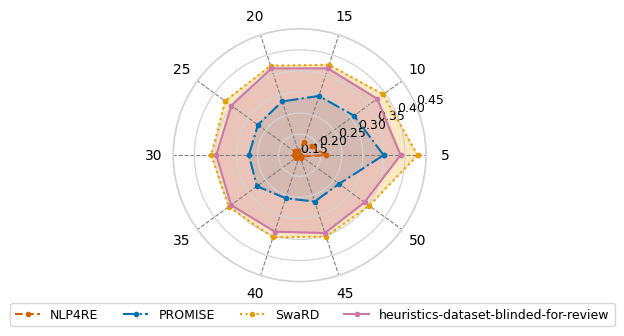

In [19]:
datasets = sorted(results_df['dataset'].unique())
num_vars = len(topic_range)


angles = np.linspace(0, 2 * np.pi, num_vars, endpoint = False).tolist()
angles += angles[:1]  # close the loop


custom_colors = ["#D55E00", "#0072B2", "#E69F00", "#CC79A7"]

line_styles = ['--', '-.', ':', '-']


fig, ax = plt.subplots(figsize = (5, 5), subplot_kw = dict(polar=True))
ax.set_facecolor('white')


for i, name in enumerate(datasets):
    group = results_df[results_df['dataset'] == name].sort_values('n_topics')
    values = group['normalized_entropy'].tolist()
    values += values[:1] 

    ax.plot(
        angles, values,
        label = name,
        color = custom_colors[i % len(custom_colors)],
        linewidth = 1.5,
        linestyle = line_styles[i % len(line_styles)],
        marker = '.'
    )
    ax.fill(
        angles, values,
        color = custom_colors[i % len(custom_colors)],
        alpha = 0.08 * (i + 1)
    )


min_val = results_df['normalized_entropy'].min()
max_val = results_df['normalized_entropy'].max()

# Rounded bounds for nice radial grid
radial_min = np.floor(min_val * 20) / 20
radial_max = np.ceil(max_val * 20) / 20
radial_ticks = np.arange(radial_min, radial_max + 0.001, 0.05)

ax.set_ylim(radial_min, radial_max)
ax.set_yticks(radial_ticks)
ax.set_yticklabels([f"{t:.2f}" for t in radial_ticks], fontsize = 9)


ax.set_xticks(angles[:-1])
ax.set_xticklabels([str(t) for t in topic_range], fontsize = 10)

ax.yaxis.grid(True, color = 'lightgray', linestyle = '-', linewidth = 0.9)
ax.xaxis.grid(True, color='gray', linestyle = '--')
ax.spines['polar'].set_color('lightgray')
ax.spines['polar'].set_linewidth(1.2)


ax.legend(loc = 'center', bbox_to_anchor = (0.55, -0.13), ncol = 5, fontsize = 9)
# ax.set_title("Normalized Entropy Across Topic Counts", pad = 20, fontsize = 12)


plt.tight_layout()
plt.savefig('./topics_diversity.pdf', dpi = 300)
plt.show()

## Combining All Metrics Togather 

In [20]:
dfs = list(dataframes.values())
names = list(dataframes.keys())

stats = []
for df, name in zip(dfs, names):
    s = basic_stats(df, name)
    s['Lexical Diversity'] = lexical_metrics(df)
    s['Domain Diversity'] = domain_diversity(df)
    stats.append(s)


stats_df = pd.DataFrame(stats)
# stats_df = pd.DataFrame(stats, index=names).T

In [21]:
stats_df

,Dataset,#Requirements,Avg Words Per Requirement,Avg Sentences Per Requirement,Vocabulary Size,Lexical Diversity,Domain Diversity
0,SwaRD,10201,20.194491,1.000000,8148,0.833763,0.375244
1,heuristics-dataset-blinded-for-review,12080,83.935596,3.304222,11170,0.875788,0.366632
2,PROMISE,969,19.317853,1.186791,2010,0.793894,0.297846
3,NLP4RE,212,32.688679,1.009434,1120,0.802572,0.182638
